In [1]:
!pip install keras-cv
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.8/615.8 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from kerastuner.tuners import RandomSearch
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

<ipython-input-2-e8eeb40542a4>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Load and Pre-process Data

In [3]:
(img_train, label_train), (img_test, label_test) = keras.datasets.cifar10.load_data()
img_train.shape

170498071/170498071 [==============================] - 2s 0us/step


(50000, 32, 32, 3)

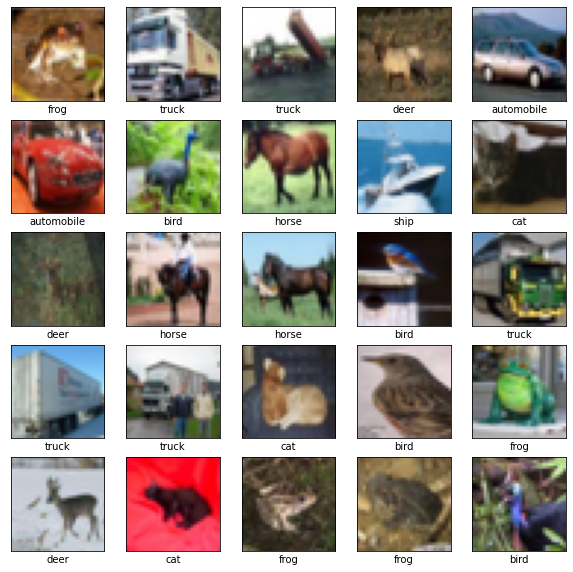

In [4]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing some of the images from the training dataset
plt.figure(figsize=[10,10])
for i in range (25):    # for first 25 images
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img_train[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[label_train[i][0]])

plt.show()

In [5]:
# Converting the pixels data to float type and Standardizing (255 is the total number of pixels an image can have)
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

# One hot encoding the target class (labels)
num_classes = 10
label_train = tf.keras.utils.to_categorical(label_train, num_classes)
label_test = tf.keras.utils.to_categorical(label_test, num_classes)

## Base model

In [6]:
def model_builder():
  model = keras.Sequential()
  model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(num_classes, activation='softmax'))    # num_classes = 10
  
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [7]:
model = model_builder()
history = model.fit(img_train, label_train, batch_size=64, epochs=30,
                    validation_data=(img_test, label_test))

Epoch 1/30
782/782 [==============================] - 17s 11ms/step - loss: 1.6197 - accuracy: 0.4094 - val_loss: 1.4391 - val_accuracy: 0.4726
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 1.2167 - accuracy: 0.5664 - val_loss: 2.4039 - val_accuracy: 0.3806
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 1.1025 - accuracy: 0.6084 - val_loss: 1.1731 - val_accuracy: 0.5950
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 1.0290 - accuracy: 0.6382 - val_loss: 1.1108 - val_accuracy: 0.6388
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9786 - accuracy: 0.6537 - val_loss: 1.0054 - val_accuracy: 0.6508
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9324 - accuracy: 0.6725 - val_loss: 0.8084 - val_accuracy: 0.7110
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9028 - accuracy: 0.6834 - val_loss: 0.9646 - val_accuracy: 0.6619
Epoc

## Keras Tuner

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [9]:
def build_model(hp):
    model = keras.Sequential()

    for i in range(hp.Int('conv_blocks', min_value= 1, max_value=5)):
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
        model.add(layers.BatchNormalization())
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D(pool_size=(2,2)))
        
        rate = hp.Choice('Dropout rate in conv',[0.1,0.2,0.3,0.4,0.5])
        model.add(layers.Dropout(rate))

  
    model.add(layers.GlobalAveragePooling2D())
    
    dense_size = layers.Dense(hp.Int('dense size',min_value = 32, max_value = 256, step=32), activation='relu')
    model.add(layers.Dense(128, activation='relu'))
    
    model.add(layers.BatchNormalization())
    
    rate = hp.Choice('Dropout rate in dense',[0.1,0.2,0.3,0.4,0.5])
    model.add(layers.Dropout(rate))
    
    model.add(layers.Dense(10, activation='softmax'))

    lr = hp.Float('lr',min_value=1e-6,max_value=1e-3)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [10]:
tuner_search = RandomSearch(build_model,objective='val_accuracy',max_trials=5)

In [12]:
tuner_search.search(img_train, label_train, epochs=3, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(patience=4)])

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.5332000255584717

Best val_accuracy So Far: 0.5914000272750854
Total elapsed time: 00h 02m 41s


## Train best model

In [13]:
best_model = tuner_search.get_best_models()[0]
best_hps= tuner_search.get_best_hyperparameters(1)[0]

In [14]:
print("conv_blocks: "+str(best_hps.get('conv_blocks')))
print("Dropout rate in conv: "+str(best_hps.get('Dropout rate in conv')))
print("dense size: "+str(best_hps.get('dense size')))
print("Dropout rate in dense: "+str(best_hps.get('Dropout rate in dense')))
print("lr: "+str(best_hps.get('lr')))

conv_blocks: 3
Dropout rate in conv: 0.3
dense size: 192
Dropout rate in dense: 0.5
lr: 0.000474598600016091


In [15]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [16]:
history = best_model.fit(img_train, label_train, validation_data= (img_test,label_test), batch_size=64, epochs=30)

Epoch 1/30
782/782 [==============================] - 9s 10ms/step - loss: 1.1476 - accuracy: 0.5873 - val_loss: 1.0535 - val_accuracy: 0.6168
Epoch 2/30
782/782 [==============================] - 7s 9ms/step - loss: 1.0859 - accuracy: 0.6111 - val_loss: 1.0127 - val_accuracy: 0.6326
Epoch 3/30
782/782 [==============================] - 7s 9ms/step - loss: 1.0279 - accuracy: 0.6339 - val_loss: 1.0178 - val_accuracy: 0.6302
Epoch 4/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9845 - accuracy: 0.6496 - val_loss: 0.9855 - val_accuracy: 0.6453
Epoch 5/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9464 - accuracy: 0.6669 - val_loss: 0.9099 - val_accuracy: 0.6798
Epoch 6/30
782/782 [==============================] - 7s 9ms/step - loss: 0.9155 - accuracy: 0.6785 - val_loss: 0.8595 - val_accuracy: 0.6947
Epoch 7/30
782/782 [==============================] - 7s 9ms/step - loss: 0.8895 - accuracy: 0.6881 - val_loss: 0.8427 - val_accuracy: 0.6976
Epoch

## Evaluate best model

In [17]:
y_pred=np.argmax(best_model.predict(img_test), axis=-1)
y_true=np.argmax(label_test,axis=1)
print("F1 Score: ", f1_score(y_true, y_pred, average='micro'))
print("Precision Score: ", precision_score(y_true, y_pred, average='micro'))
print("Recall Score: ", recall_score(y_true, y_pred, average='micro'))

313/313 [==============================] - 1s 2ms/step
F1 Score:  0.7918
Precision Score:  0.7918
Recall Score:  0.7918


## Analyse with Confusion Matrix

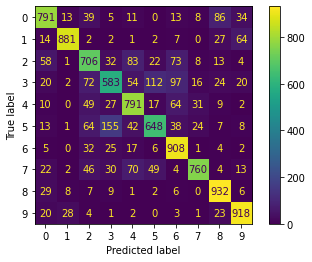

True positive:  791
False positive:  13
False negative:  14
True negative:  881


In [18]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.arange(10))

cm_display.plot()
plt.show()

print('True positive: ', cm[0][0])
print('False positive: ', cm[0][1])
print('False negative: ', cm[1][0])
print('True negative: ', cm[1][1])